# Experiment with Sine function

In this experiment, we try to build models using Keras framework to learn and predict the sine function.
We test several parameters and check how well the networks learn and generalize.

**NOTE:** The model train methods were unified into a generalized method that could receive the hyperparameters and build distinct neural networks.

## 1. Desktop used to run the experiment

- Computador Dell XPS-8930-A5GM
- Intel i7 8700
- RAM 16GB
- HD 2TB
- GeForce GTX 1050 Ti 4GB

## 2. Libraries

- Keras 2.4.3 (Using GPU)
- Tensorflow 2.4.1 (Using GPU)


## 3. Importing required libraries

In [63]:
import os

import pandas as pd
import numpy as np
import math

from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from datetime import datetime

from IPython.display import Image, display

## 4. Data preparation

In this assignment, the function was modified to allow changes on the train/test sets sizes, noise scale, etc.


In [64]:
def prepare_data(noise_scale=0.1, test_size=0.15,  out_start=0, out_end=2*np.pi, ntot=100, outpath="image.png"):

    
    # Proportion of train size
    train_size = 1 - test_size
    
    # Number of training examples
    ntrain = int(train_size * ntot)

    # Number of test examples
    ntest = int(test_size * ntot)

    #
    #  range of values from random number function generator
    #
    in_start = 0
    in_end = 1
    
    #
    # Mapping the original values of random to the disired scale
    #
    slope = (out_end - out_start) / (in_end - in_start)
    in_value = np.random.rand(ntot,1) 
    
    #
    # Final dataset
    #
    x = out_start + slope * (in_value - in_start)

    #
    # Generating noise
    #
    s=np.random.normal(0, noise_scale, size = (ntot,1))

    #
    # Generating output
    #
    y=np.sin(x)+s

    #
    # Dataset splitting
    #
    xtrain, xtest = x[:ntrain], x[ntrain:]
    ytrain, ytest = y[:ntrain], y[ntrain:]

    # Visualizing the train set using scatter splot
    plt.plot(xtrain.T,ytrain.T,color = 'red', marker = "o")
    plt.title("seno")
    plt.xlabel("Angulo")
    plt.ylabel("Seno")
    plt.grid()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

    return xtrain, ytrain, xtest, ytest

In [65]:
def fit_model(xtrain, ytrain, xtest, ytest, epochs, lr=0.05, ns=0.1, momentum=0.8, patience=100, batch_size=5, activation="tahn", hidden_layer_size=10):
    """
    Method to train Networks 
    """

    tf.keras.backend.clear_session()
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    # define model
    model = Sequential([Dense(hidden_layer_size, activation=activation, input_dim=1),
                        Dense(1, activation='linear')
                       ])
                       
    # compile model
    opt = SGD(lr, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    # fit model
    history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=epochs,  batch_size=batch_size, verbose=0, callbacks=[early_stop])

    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('learning rate='+str(lr), pad=-80)

    plt.legend()
    output_path = "imgs/model_loss_ns=%.2f_epochs=%d_lr=%.3f_mom=%.2f_activation=%s_pati=%d_hidden=%d.png"  %(ns, epochs, lr, momentum, activation, patience, hidden_layer_size)
    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.close()

    
    return model

## 5. Report for the Exercise

In this report, we try different setups of noise scale (ns), activation functions (af), learning rates (lr), patience

Note: The code for this assignment is available at: https://github.com/thiagordp/iac_exercises/tree/main/exercicio4sine

In [66]:
#
# Creating hyperparameters options
#

noise_scale_list = [0.05, 0.1, 0.2]
act_func_list = ["sigmoid", "relu", "tanh"]
lr_list = [0.005, 0.01, 0.05, 0.1]
patience_list = [100, 200]
hidden_layer_list = [5, 10, 50, 100]

epochs = 2000

# Min and max value of sin function to learn
min_value = 0
max_value = 2*np.pi
batch_size=5

test_ratio = 0.3

num_examples = 100

In the following code, we run the experiments for all combinations of hyperparameters

_Note:_ In our computer, we run the experiments using Keras on GPU and this step took ~2 hours.


In [67]:

data = []
for ns in noise_scale_list:
    for act_funct in act_func_list:
        for lr in lr_list:
            for patience in patience_list:
                for hidden_layer_size in hidden_layer_list:
                    now = datetime.now()
                    print("=== (%s)Training network (ns: %.2f, act_funct: %s; lr: %.3f; patience:%d, hidden_layer_size:%d) ===" % (now.strftime("%d/%m/%Y %H:%M:%S"), ns, act_funct, lr, patience, hidden_layer_size))

                    #
                    # Preparing dataset
                    #
                    out_path="imgs/dataset_ns=%.2f_activation=%s_lr=%.3f_pati=%d_hidden=%d.png"  % (ns, act_funct, lr, patience, hidden_layer_size)
                    xtrain, ytrain, xtest, ytest = prepare_data(
                        ntot=num_examples, 
                        noise_scale=ns, 
                        out_start=0, out_end=max_value, 
                        test_size=test_ratio,
                        outpath=out_path
                    )

                    scaler = preprocessing.MinMaxScaler()
                    # fit using the train set
                    scaler.fit(xtrain)
                    # transform the test test
                    xtrainN = scaler.transform(xtrain)
                    xtestN = scaler.transform(xtest) 

                    X = np.linspace(0.0 , 2.0 * np.pi, num_examples).reshape(-1, 1)
                    XN = scaler.transform(X)

                    #
                    # Fitting model
                    #
                    
                    model = fit_model(
                        xtrainN, ytrain, xtestN, ytest, epochs=epochs, lr=lr, activation=act_funct, 
                        patience=patience, hidden_layer_size=hidden_layer_size, batch_size=batch_size
                    )

                    #
                    # Making predictions
                    #
                    Y = model.predict(XN)
                    plt.plot(XN,Y,color = 'red', marker = "o", label="model prediction")
                    plt.plot(xtestN.T,ytest.T,color = 'black', marker= "+")
                    plt.title("seno")
                    plt.xlabel("Angulo")
                    plt.ylabel("Seno")
                    plt.grid()
                    output_path = "imgs/prediction_ns=%.2f_activation=%s_lr=%.3f_pati=%d_hidden=%d.png"  % (ns, act_funct, lr, patience, hidden_layer_size)
                    plt.tight_layout()
                    plt.legend()
                    plt.savefig(output_path, dpi=200)
                    plt.close()

                    y_pred = model.predict(xtestN)
                    mse = mean_squared_error(ytest, y_pred)

                    data.append([ns, act_funct, lr, patience, hidden_layer_size, mse])

df = pd.DataFrame(data, columns=[    "Ns",    "Activation",    "Lr", "patience","hidden_layer", "mse"])
df.to_excel("results.xlsx", index=False)

=== (17/06/2022 14:01:21)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:100, hidden_layer_size:5) ===
=== (17/06/2022 14:01:43)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:100, hidden_layer_size:10) ===
=== (17/06/2022 14:01:52)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:100, hidden_layer_size:50) ===
=== (17/06/2022 14:02:06)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:100, hidden_layer_size:100) ===
=== (17/06/2022 14:02:14)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:200, hidden_layer_size:5) ===
=== (17/06/2022 14:03:56)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:200, hidden_layer_size:10) ===
=== (17/06/2022 14:04:10)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:200, hidden_layer_size:50) ===
=== (17/06/2022 14:04:26)Training network (ns: 0.05, act_funct: sigmoid; lr: 0.005; patience:200, hidden_layer_size:100) ===
=== (17/

## Results Analysis

After experimenting all the combinations for the selected hyperparameters, we will run some analysis using the spreadsheet we exported after the training step and also using the charts for the predictions made by the network compared to the test set.

### Analysis of the impact of hyperparameters on MSE

First, we analyse the impact of each hyperparameter value on the MSE for test set.

In [68]:
df = pd.read_excel("results.xlsx")

print("Checking noise scale influence")
for noise_scale in noise_scale_list:
    mse = np.mean(df[df["Ns"]==noise_scale]["mse"])
    mse_std = np.std(df[df["Ns"]==noise_scale]["mse"])

    print("noise_scale\t%s\tTest set MSE: %.3f (±%.3f)" % (noise_scale, mse, mse_std))

Checking noise scale influence
noise_scale	0.05	Test set MSE: 0.120 (±0.116)
noise_scale	0.1	Test set MSE: 0.155 (±0.149)
noise_scale	0.2	Test set MSE: 0.182 (±0.135)


In [69]:

print("Checking hidden layer Activation influence")
for activation in act_func_list:
    mse = np.mean(df[df["Activation"]==activation]["mse"])
    mse_std = np.std(df[df["Activation"]==activation]["mse"])

    print("activation\t%s\tTest set MSE: %.3f (±%.3f)" % (activation, mse, mse_std))


Checking hidden layer Activation influence
activation	sigmoid	Test set MSE: 0.185 (±0.147)
activation	relu	Test set MSE: 0.193 (±0.130)
activation	tanh	Test set MSE: 0.078 (±0.094)


In [70]:
print("Checking learning rate influence")
for lr in lr_list:
    mse = np.mean(df[df["Lr"]==lr]["mse"])
    mse_std = np.std(df[df["Lr"]==lr]["mse"])

    print("learning rate\t%.3f\tTest set MSE: %.3f (±%.3f)" % (lr, mse, mse_std))


Checking learning rate influence
learning rate	0.005	Test set MSE: 0.172 (±0.105)
learning rate	0.010	Test set MSE: 0.138 (±0.105)
learning rate	0.050	Test set MSE: 0.123 (±0.118)
learning rate	0.100	Test set MSE: 0.176 (±0.190)


In [71]:
print("Checking patience influence")
for patience in patience_list:
    mse = np.mean(df[df["patience"]==patience]["mse"])
    mse_std = np.std(df[df["patience"]==patience]["mse"])

    print("patience\t%d\tTest set MSE: %.3f (±%.3f)" % (patience, mse, mse_std))

Checking patience influence
patience	100	Test set MSE: 0.161 (±0.133)
patience	200	Test set MSE: 0.143 (±0.139)


In [72]:
print("Checking hidden layer size influence")
for hidden_layer in hidden_layer_list:
    mse = np.mean(df[df["hidden_layer"]==hidden_layer]["mse"])
    mse_std = np.std(df[df["hidden_layer"]==hidden_layer]["mse"])

    print("hidden_layer\t%d\tTest set MSE: %.3f (±%.3f)" % (hidden_layer, mse, mse_std))

Checking hidden layer size influence
hidden_layer	5	Test set MSE: 0.122 (±0.147)
hidden_layer	10	Test set MSE: 0.117 (±0.103)
hidden_layer	50	Test set MSE: 0.166 (±0.112)
hidden_layer	100	Test set MSE: 0.203 (±0.156)


From the above experiments, in *average* one can note the following:

- In terms of **noise scale**
    - It was expected the increase on MSE when training network on noisier data. 
    - In the next analysis, we will see whether the models learned the sine function regardless the noise in the data
- In terms of **Hidden layer activation function**
    - By far, `tanh` was the best performed activation function. One possible explanation is that, due to the relationship between tangent and sine functions, such activation function could better learn the sine function.
    - The `ReLu` and `sigmoid` functions could also learn the sine function, but with poorer performance.
- In terms of **learning rate**:
    - One can see that both lower and higher values of LR performed poorer on MSE
    - The mean term, i.e., $lr=0.05$ achieved the best MSE, in average.
- In terms of **patience** in Early stopping:
    - The two values tested do not had,  on average, a significant difference in MSE.
- In terms of **Hidden Layer size**:
    - Simpler networks were the best perfomant ones on MSE.
    - IN this dataset, we would choose a hidden layer size of $10$ and still get good results.

### Analysing the predictions of the best models.

In this section, we analyse predictions from the best models (according to MSE).

#### Predictions and Noise Scale


In [73]:
ns_df = df[
    (df["Ns"]==0.2) 
]
ns_df.sort_values(by=["mse"], ascending=True).head(n=1)

,Ns,Activation,Lr,patience,hidden_layer,mse
234,0.2,relu,0.01,100,50,0.027932


The best model has `sigmoid` as activation, lr=0.1, patience=100 and hidden layer=10
We show the predictions for this case below

One can see that, even when adding a noticeable noise, this set of hyperparameters could sucessfully learn the sine function.
However, there is space for improvements. Such as, the curve smoothness.

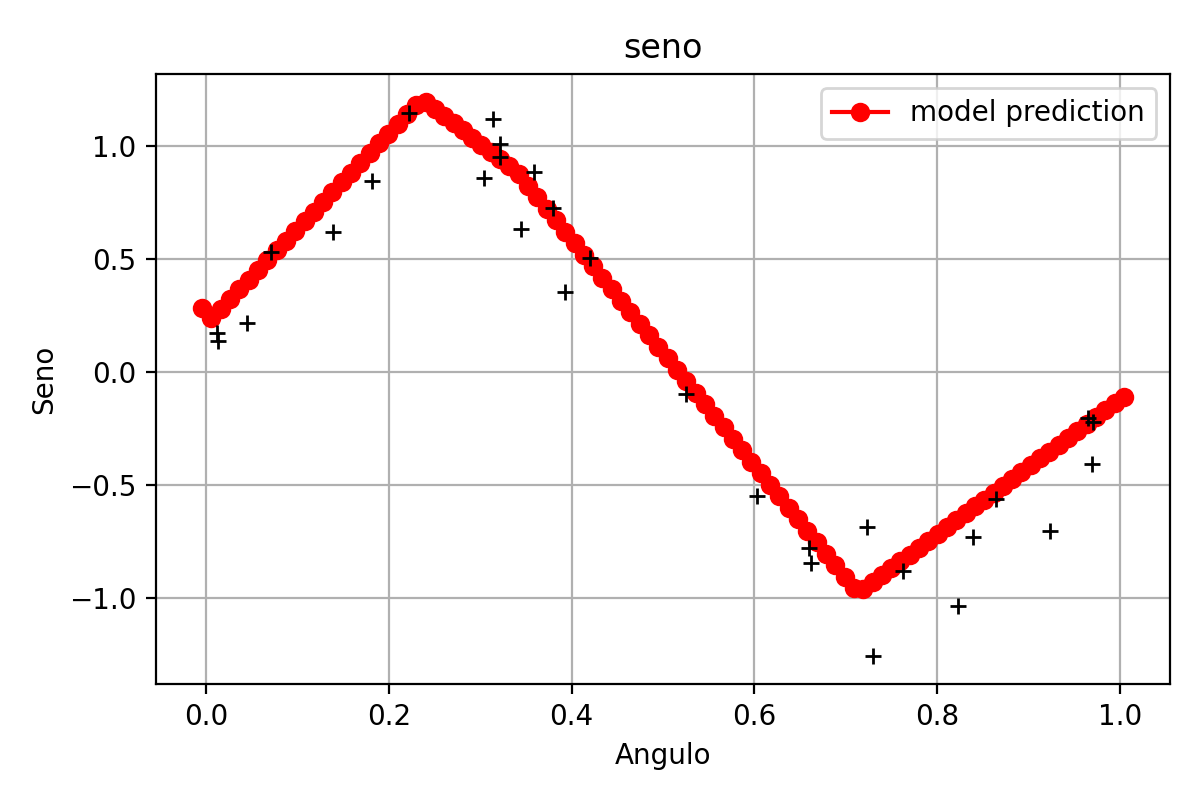

In [90]:
imageName = "imgs/prediction_ns=0.20_activation=relu_lr=0.010_pati=100_hidden=50.png"
display(Image(filename=imageName))

## Analysis according to activation

We now try some activations. We show the best models for each activation

One can note that:
- Both `tanh` and `sigmoid` are sucessful in learning the sine function and also the curve smoothness
- The `relu` on the other hand, sucessfully learns the sine, however, the learned function is not smooth.

In [91]:
# Analysing 'tanh'

ns_df = df[
    (df["Activation"]=="tanh") & 
    (df["Ns"]==0.1)  
]
ns_df.sort_values(by=["mse"], ascending=True).head(n=1)

,Ns,Activation,Lr,patience,hidden_layer,mse
164,0.1,tanh,0.005,200,5,0.00807


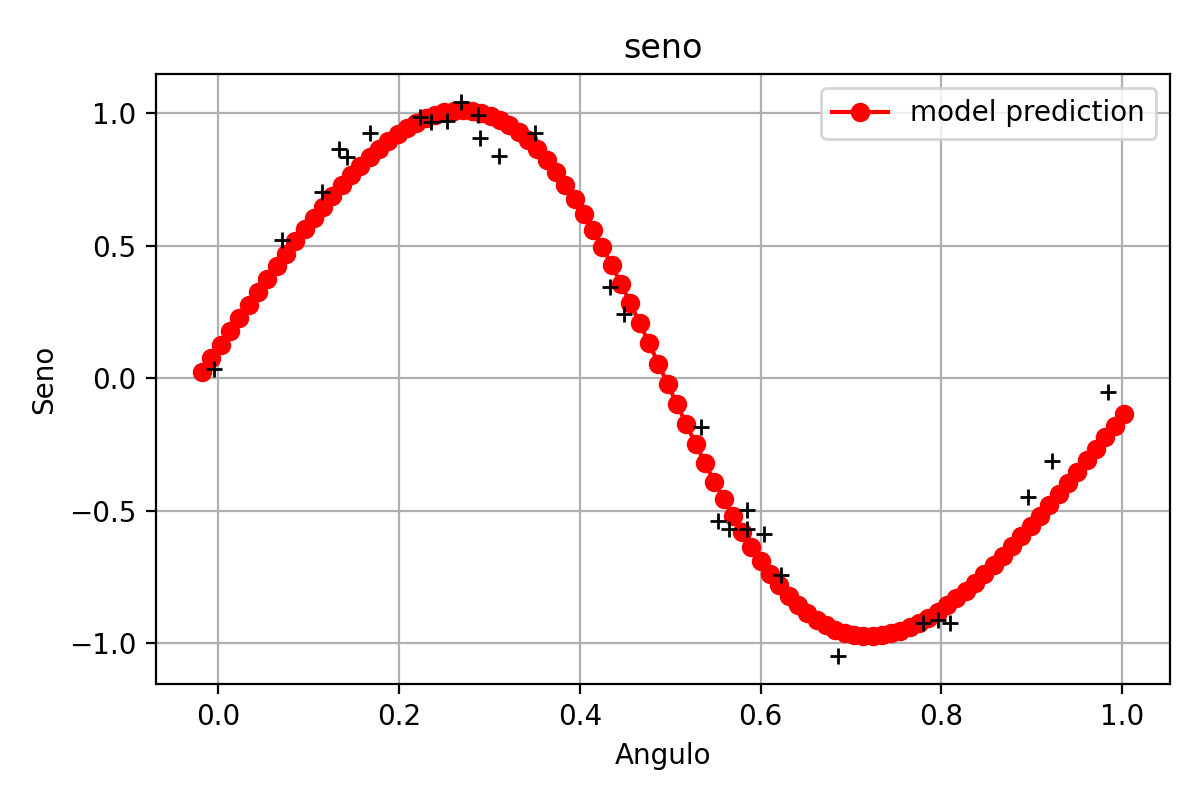

In [92]:
imageName = "imgs/prediction_ns=0.10_activation=tanh_lr=0.005_pati=200_hidden=5.png"
display(Image(filename=imageName))

In [93]:
# Analysing 'relu'

ns_df = df[
    (df["Activation"]=="relu") & 
    (df["Ns"]==0.1)  
]
ns_df.sort_values(by=["mse"], ascending=True).head(n=1)

,Ns,Activation,Lr,patience,hidden_layer,mse
134,0.1,relu,0.005,200,50,0.01318


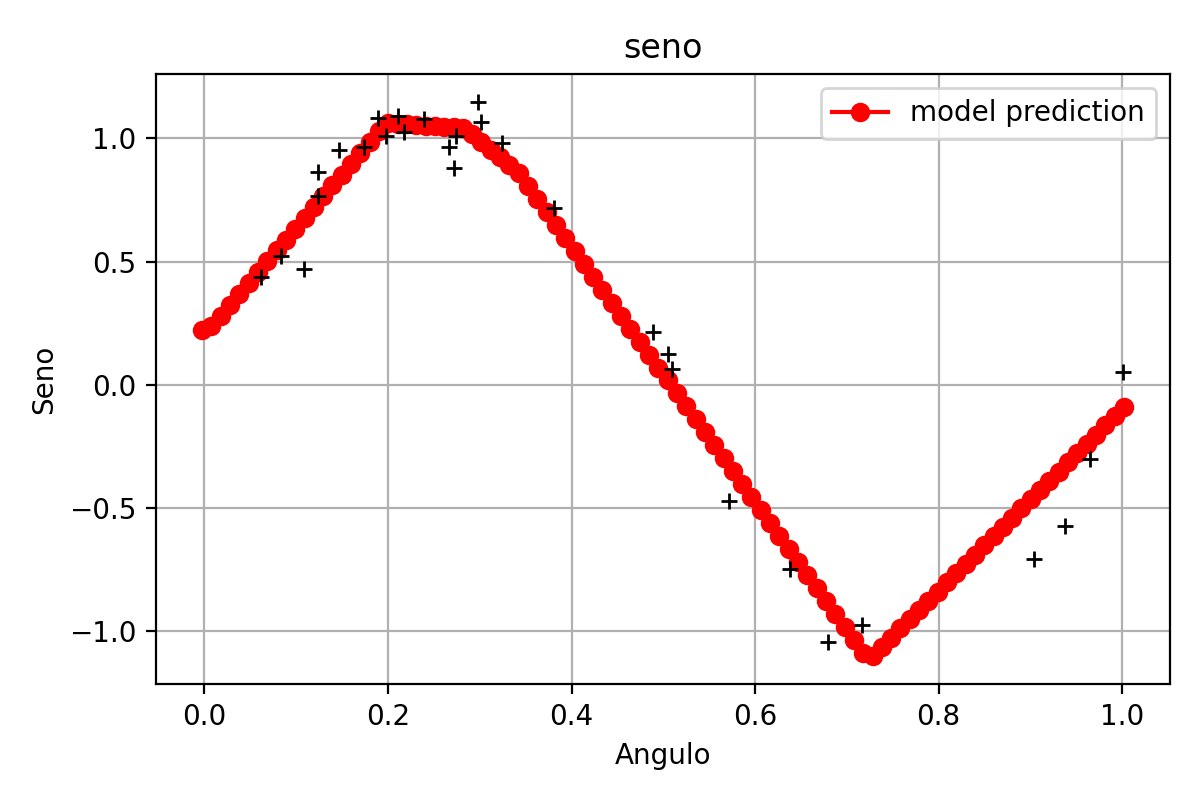

In [94]:
imageName = "imgs/prediction_ns=0.10_activation=relu_lr=0.005_pati=200_hidden=50.png"
display(Image(filename=imageName))

In [95]:
# Analysing 'sigmoid'

ns_df = df[
    (df["Activation"]=="sigmoid") & 
    (df["Ns"]==0.1)  
]
ns_df.sort_values(by=["mse"], ascending=True).head(n=1)

,Ns,Activation,Lr,patience,hidden_layer,mse
112,0.1,sigmoid,0.05,100,5,0.007256


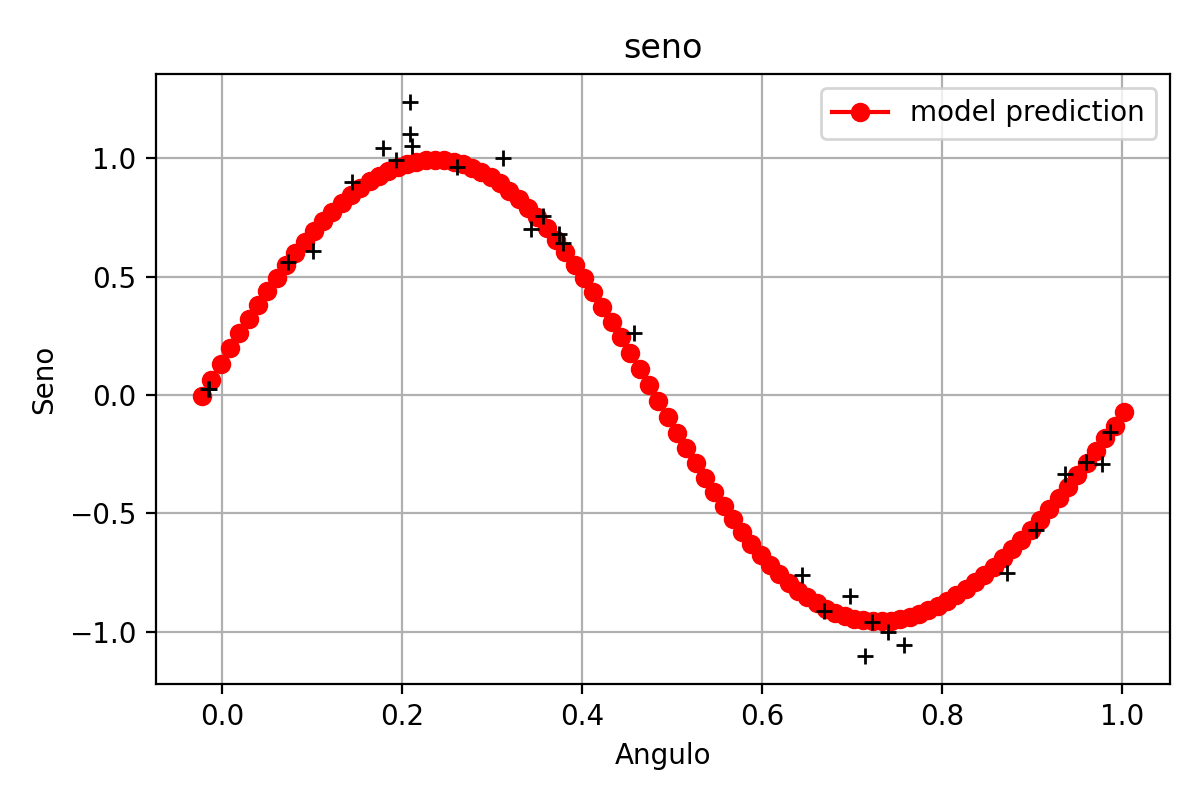

In [96]:
imageName = "imgs/prediction_ns=0.10_activation=sigmoid_lr=0.050_pati=100_hidden=5.png"
display(Image(filename=imageName))

## Analysis according to learning rate

We now try some learning rates. We show the best models for each.

One can note that:
- Both learning rates enable the networks to learn the sine function

In [97]:
# Analysing lr=0.05

ns_df = df[
    (df["Lr"]==0.05) & 
    (df["Ns"]==0.1)  
]
ns_df.sort_values(by=["mse"], ascending=True).head(n=1)

,Ns,Activation,Lr,patience,hidden_layer,mse
112,0.1,sigmoid,0.05,100,5,0.007256


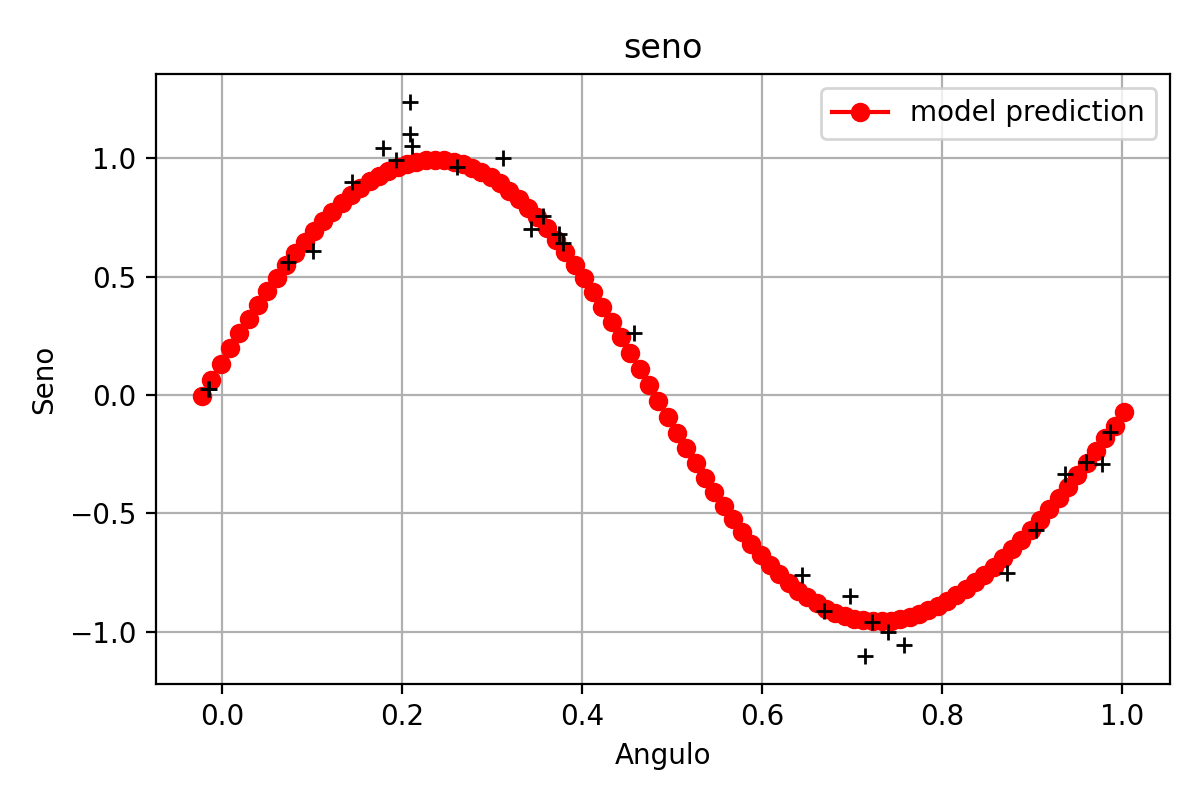

In [98]:
imageName = "imgs/prediction_ns=0.10_activation=sigmoid_lr=0.050_pati=100_hidden=5.png"
display(Image(filename=imageName))

In [83]:
# Analysing lr=0.1

ns_df = df[
    (df["Lr"]==0.1) & 
    (df["Ns"]==0.1)  
]
ns_df.sort_values(by=["mse"], ascending=True).head(n=1)

,Ns,Activation,Lr,patience,hidden_layer,mse
124,0.1,sigmoid,0.1,200,5,0.009034


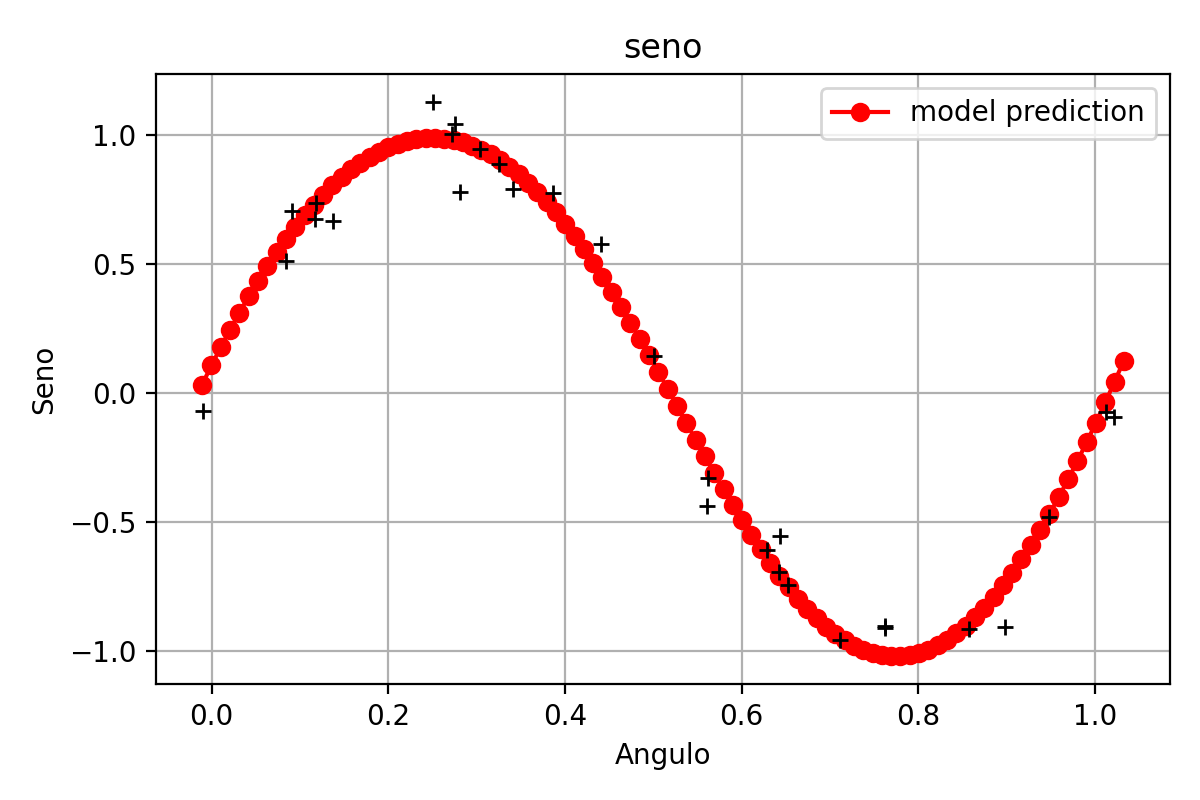

In [99]:
imageName = "imgs/prediction_ns=0.10_activation=sigmoid_lr=0.100_pati=200_hidden=5.png"
display(Image(filename=imageName))

## Analysis of the relationship between noise scale and hidden layer size

In the following, we try to understand whether more neurons are required to *handle* when adding more noise to the data.


In [85]:
ns_df = pd.pivot_table(df, values="mse", index=["Ns"],columns=["hidden_layer"], aggfunc=np.mean)
ns_df

hidden_layer,5,10,50,100
Ns,,,,
0.05,0.085659,0.085139,0.133896,0.173906
0.10,0.121203,0.124471,0.168085,0.204821
0.20,0.159469,0.140712,0.197198,0.228997


We also experiment other combinations of hyperparameters

In [86]:
ns_df = pd.pivot_table(df, values="mse", index=["Ns"],columns=["Lr"], aggfunc=np.mean)
ns_df

Lr,0.005,0.010,0.050,0.100
Ns,,,,
0.05,0.142631,0.114166,0.091872,0.129930
0.10,0.159346,0.147869,0.123111,0.188254
0.20,0.214476,0.150715,0.152704,0.208482


In [87]:
ns_df = pd.pivot_table(df, values="mse", index=["Lr"],columns=["hidden_layer"], aggfunc=np.mean)
ns_df

hidden_layer,5,10,50,100
Lr,,,,
0.005,0.174911,0.126821,0.192156,0.194716
0.010,0.075309,0.169484,0.133442,0.172098
0.050,0.083256,0.067763,0.157132,0.182098
0.100,0.154965,0.103028,0.182842,0.261387


In [88]:
ns_df = pd.pivot_table(df, values="mse", index=["Activation"],columns=["hidden_layer"], aggfunc=np.mean)
ns_df

hidden_layer,5,10,50,100
Activation,,,,
relu,0.243604,0.179106,0.177134,0.173356
sigmoid,0.060857,0.116043,0.233041,0.329511
tanh,0.061870,0.055173,0.089005,0.104857


In [89]:
ns_df = pd.pivot_table(df, values="mse", index=["Activation"],columns=["Lr"], aggfunc=np.mean)
ns_df

Lr,0.005,0.010,0.050,0.100
Activation,,,,
relu,0.157945,0.135528,0.187786,0.291941
sigmoid,0.200232,0.201179,0.145774,0.192267
tanh,0.158277,0.076043,0.034126,0.042458
